In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from malnis import show
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm
import scipy.sparse as sp
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, SparsePCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, auc, roc_auc_score, average_precision_score, PrecisionRecallDisplay
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from skorch import NeuralNetClassifier

/home/jarobyte/envs/malnis/lib/python3.8/site-packages/huggingface_hub/snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(


In [2]:
pwd

'/home/jarobyte/malnis_dataset/notebooks'

In [3]:
# The number of sentences in each paper goes from 59 to 4,447. I truncate to 512.

data = pd.read_pickle("../data/labels.pkl")\
.assign(n_sentences = lambda df: df.sentences.map(len))\
.query("n_sentences <= 512")\
.reset_index(drop = True)

show(data, 20)

(275, 9)


,query,document,summary,r1,r2,rl,sentences,relevance,n_sentences
0,"For many types of machine learning algorithms,...","field in computer science, and health informat...",[While the techniques for neural networks are ...,0.594595,0.485714,0.594595,"[field in computer science, and health informa...","[False, False, False, False, False, False, Fal...",256
1,We consider the problem of learning good traje...,"field in computer science, and health informat...",[[71] considered the problem of learning good ...,0.646766,0.478571,0.636816,"[field in computer science, and health informa...","[False, False, False, False, False, False, Fal...",256
2,"HDBSCAN*, a state-of-the-art density-based hie...",PVLDB Reference Format: Antonio Cavalcante Ara...,"[In [6], the authors proposed RNG-HDBSCAN*, a ...",0.539062,0.350365,0.507812,[PVLDB Reference Format: Antonio Cavalcante Ar...,"[False, False, False, False, False, False, Fal...",124
3,This work investigates continual learning of t...,Fully automatic deep learning has become the s...,[Baweja et al. (2018) investigate continual le...,0.480769,0.317690,0.442308,[Fully automatic deep learning has become the ...,"[False, False, False, False, False, False, Fal...",449
4,Query relevance ranking and sentence saliency ...,Keywords: Query-focused summarization · Extrac...,[There exist approaches utilizing attention me...,0.500000,0.293333,0.490566,[Keywords: Query-focused summarization · Extra...,"[False, False, True, False, False, False, Fals...",266
5,The key idea behind active learning is that a ...,I. INTRODUCTION Deep Neural Networks (DNNs) tr...,[The key idea behind active learning is that a...,0.368664,0.282828,0.368664,"[I., INTRODUCTION Deep Neural Networks (DNNs) ...","[False, False, False, False, False, False, Fal...",238
6,When AI systems interact with humans in the lo...,22 22 23 23 24 24 25 25 26 26 27 27 28 28 29 2...,[• Approaches: Past work on explanations prima...,0.330827,0.278075,0.330827,[22 22 23 23 24 24 25 25 26 26 27 27 28 28 29 ...,"[False, False, False, False, False, False, Fal...",166
7,Pre-training techniques have been verified suc...,Visually-rich Document Understanding (VrDU) ai...,"[To this end, the second direction relies on t...",0.459259,0.265000,0.437037,[Visually-rich Document Understanding (VrDU) a...,"[False, False, True, False, False, False, Fals...",252
8,We rigorously evaluate three state-of-the-art ...,"The Transformer (Vaswani et al., 2017) has bec...",[This agrees with the observations made in wor...,0.406593,0.264957,0.395604,"[The Transformer (Vaswani et al., 2017) has be...","[False, False, False, False, False, False, Fal...",233
9,We introduce a novel type of text representati...,We experiment on real world invoice and resume...,[Chargrid [14] models the problem by encoding ...,0.423358,0.258427,0.423358,[We experiment on real world invoice and resum...,"[False, False, False, False, False, False, Fal...",301


<AxesSubplot:ylabel='Frequency'>

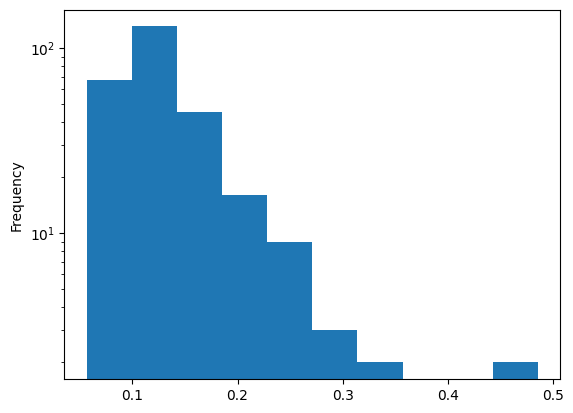

In [4]:
data.r2.plot.hist(log = True)

In [5]:
data["query"][36]

'We introduce the author-topic model, a generative model for documents that extends Latent Dirichlet Allocation (LDA; Blei, Ng, & Jordan, 2003) to include authorship information. Each author is associated with a multinomial distribution over topics and each topic is associated with a multinomial distribution over words. A document with multiple authors is modeled as a distribution over topics that is a mixture of the distributions associated with the authors. We apply the model to a collection of 1,700 NIPS conference papers and 160,000 CiteSeer abstracts. Exact inference is intractable for these datasets and we use Gibbs sampling to estimate the topic and author distributions. We compare the performance with two other generative models for documents, which are special cases of the author-topic model: LDA (a topic model) and a simple author model in which each author is associated with a distribution over words rather than a distribution over topics. We show topics recovered by the aut

In [6]:
[s for s, l in zip(data.sentences[36], data.relevance[36]) if l == True]

['The dynamic mixture model (DMM) [36] considers a single dynamic sequence of documents, which corresponds to a single topic over time.',
 'We sample the topic assignment z for each word-pair instead of each independent word.',
 'UCT captures a user’s interests at time t as θt,u, that is, as a distribution over mixtures of topics.',
 '(6) Inference is intractable in this model.',
 'This is a traditional clustering algorithm [16].',
 'Latent Dirichlet Allocation (LDA).',
 'We evaluate the performance with the above metrics at each time period, and report the mean of the evaluation results.',
 'The author-topic model for authors and documents.',
 'Dynamic mixture models for multiple time-series.']

In [7]:
sum(data.relevance[36])

9

In [8]:
len(data.relevance[36])

456

In [9]:
model = SentenceTransformer(
    "sbert"
#     'all-MiniLM-L6-v2', 
#     cache_folder = "../assets"
#     "../cache/huggingface/transformers/"
#     cache_folder = "../cache/huggingface/transformers"
)
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [10]:
query_embeddings = model.encode(data["query"])
query_embeddings.shape

(275, 384)

In [11]:
dims = query_embeddings.shape[1]
sentence_embeddings = [
    model.encode(l)#.toarray() 
    for l in tqdm(data.sentences)
]
all([l.shape[1] == dims for l in sentence_embeddings])

  0%|          | 0/275 [00:00<?, ?it/s]

True

In [12]:
query_embeddings.shape[0] == len(sentence_embeddings)

True

In [13]:
sum([len(l) for l in tqdm(data.sentences)])

  0%|          | 0/275 [00:00<?, ?it/s]

73124

In [14]:
# train = [
# #     ((sp.csr_matrix(np.ones([l.shape[0],1])) * q) - l).power(2)
# #     (q - l)**2
#     np.concatenate([np.tile(q, (l.shape[0], 1)), l], axis = 1)
#     for q, l in zip(tqdm(query_embeddings), sentence_embeddings)
# ]
# len(train)

In [15]:
# [x.shape for x in train[:5]]

In [16]:
# pd.Series([x.shape[0] for x in train]).describe(percentiles = np.linspace(0, 1, 11))

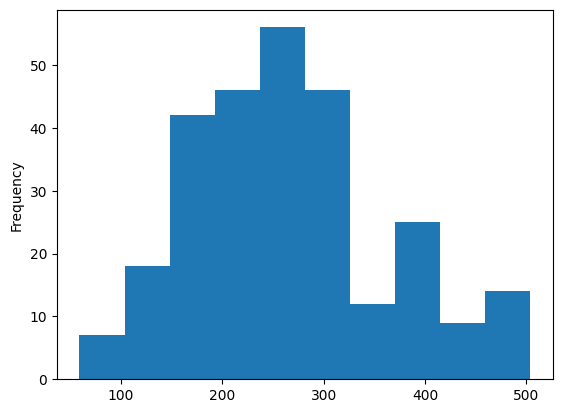

In [17]:
data.sentences.map(len).plot.hist()
plt.show()

In [18]:
# X = [torch.tensor(x) for x in train]
# all([x.shape[0] <= 512 for x in X])

In [19]:
# X = torch.nn.utils.rnn.pad_sequence(X, batch_first = False)
# X.shape

In [20]:
# X = np.concatenate(train)#.toarray().T#.squeeze()
# X.shape

In [21]:
# torch.save(X, "X__lstm_sbert_concat.npy")

In [22]:
X = torch.load("X__lstm_sbert_concat.npy")
X.shape

torch.Size([275, 504, 768])

In [23]:
Y = torch.tensor([y for l in tqdm(data.relevance) for y in l])
Y.shape

  0%|          | 0/275 [00:00<?, ?it/s]

torch.Size([73124])

In [24]:
Y = torch.nn.utils.rnn.pad_sequence([torch.tensor(x) for x in data.relevance], batch_first = True)
Y.shape

torch.Size([275, 504])

In [25]:
Y.sum()

tensor(2470)

In [26]:
# %%time
# model = LogisticRegression(
#     C = 10**-2
# )
# model.fit(X, Y)

# predictions = model.predict_proba(X)

# # predictions.sum()
# predictions.shape

In [27]:
# %%time
# model = LogisticRegression(
#     C = 10**-2
# )
# model.fit(X, Y)

# predictions = model.predict_proba(X)

# # predictions.sum()
# predictions.shape

In [28]:
# %%time
# model = SVC(
# #     C = 10**-2
# )
# model.fit(X, Y)

# predictions = model.predict_proba(X)

# # predictions.sum()
# predictions.shape

In [29]:
# %%time
# model = MLPClassifier(
# #     C = 10**-2
#     verbose = True,
# #     early_stopping = True
# )
# model.fit(X, Y)

# predictions = model.predict_proba(X)

# # predictions.sum()
# predictions.shape

In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
print("X_train", X_train.shape)
print("X_test", X_test.shape)
print("Y_train", Y_train.shape)
print("Y_test", Y_test.shape)

X_train torch.Size([206, 504, 768])
X_test torch.Size([69, 504, 768])
Y_train torch.Size([206, 504])
Y_test torch.Size([69, 504])


In [31]:
Y_train.sum(), Y_test.sum()

(tensor(1790), tensor(680))

In [32]:
# %%time

# model = MLPClassifier(
# #     C = 10**-2
#     verbose = True,
# #     early_stopping = True
# )
# model.fit(X_train, Y_train)

# predictions = model.predict_proba(X_test)

# # predictions.sum()
# predictions.shape

In [33]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size = 768,
            hidden_size = 100,
            num_layers = 1,
            bidirectional = True
        )
        self.out_layer = nn.Linear(200, 2)
        
    def forward(self, x, **kwargs):
        x = self.lstm(x)
        print(x)
        return self.out_layer(x)
    
l = LSTM()
d = X_train[:5]
print(d.shape)
l(d)

torch.Size([5, 504, 768])
(tensor([[[-6.1515e-02, -1.1650e-03,  5.6224e-03,  ...,  3.7993e-02,
           1.6307e-02,  6.7649e-02],
         [-6.3048e-02,  3.2548e-03,  1.3215e-03,  ...,  3.9316e-02,
           5.2120e-03,  6.5406e-02],
         [-6.5201e-02,  2.9311e-02,  5.0081e-03,  ...,  1.9785e-02,
           4.0859e-02,  4.1452e-02],
         ...,
         [-3.5228e-02, -1.0815e-02,  7.1415e-03,  ...,  5.6132e-02,
           4.4949e-02,  2.6575e-02],
         [-3.5228e-02, -1.0815e-02,  7.1415e-03,  ...,  5.6132e-02,
           4.4949e-02,  2.6575e-02],
         [-3.5228e-02, -1.0815e-02,  7.1415e-03,  ...,  5.6132e-02,
           4.4949e-02,  2.6575e-02]],

        [[-1.0066e-01, -1.7871e-02,  6.7002e-06,  ...,  4.2436e-02,
           1.6605e-02,  2.3631e-02],
         [-1.1764e-01,  1.3606e-02,  5.5039e-04,  ...,  3.8308e-02,
           3.4052e-02,  6.6408e-02],
         [-1.0262e-01,  3.1461e-02,  3.1650e-02,  ...,  2.7030e-02,
           4.5487e-02,  6.6837e-02],
         ...

TypeError: linear(): argument 'input' (position 1) must be Tensor, not tuple

In [ ]:
plt.hist(predictions[:, 1])
# plt.xlim(-0.1, 1.1)
plt.show()

In [ ]:
roc_auc_score(Y_test, predictions[:, 1])

In [ ]:
average_precision_score(Y_test, predictions[:, 1])

In [ ]:
f1_score(Y_test, predictions[:, 1] > 0.5)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(
    model, X_test, Y_test, name="Neural Network"
)